<a href="https://colab.research.google.com/github/bigarcia/especializacao-pece-monografia/blob/main/Monografia_Explora%C3%A7%C3%A3o_e_Testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -r requirements.txt

# Imports

In [ ]:
from pyspark.sql.functions import col, when, count, trim
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler

# Leitura do arquivo

Inicia Spark Session

In [ ]:
spark = SparkSession.builder \
    .appName("Data Cleaning") \
    .config("spark.jars", "/home/ec2-user/jars/hadoop-aws-3.3.4.jar,/home/ec2-user/jars/aws-java-sdk-bundle-1.12.375.jar") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "com.amazonaws.auth.DefaultAWSCredentialsProviderChain") \
    .getOrCreate()


Ler arquivo

In [ ]:
s3_input_path = "/content/credit_risk_dataset.csv"
df = spark.read.csv(s3_input_path, header=True, inferSchema=True)
df.show(5)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        22|        59000|                 RENT|            123.0|   PERSONAL|         D|    35000|        16.02|          1|               0.59|                        Y|                         3|
|        21|         9600|                  OWN|              5.0|  EDUCATION|         B|     1000|        11.14|          0|                0.1|                        N|                         2|
|    

Schema

In [ ]:
df.printSchema()

root
 |-- person_age: integer (nullable = true)
 |-- person_income: integer (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- person_emp_length: double (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_grade: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- loan_int_rate: double (nullable = true)
 |-- loan_status: integer (nullable = true)
 |-- loan_percent_income: double (nullable = true)
 |-- cb_person_default_on_file: string (nullable = true)
 |-- cb_person_cred_hist_length: integer (nullable = true)



#Análise dos dados

In [137]:
categorical_cols = [c for c, t in df.dtypes if t == "string"]
numeric_cols = [c for c, t in df.dtypes if t in ["double", "int"]]

In [ ]:
print(f"Total de registros: {df.count()}")


Total de registros: 32581


In [ ]:
df.select(
    "person_age", "person_income", "person_emp_length",
    "loan_amnt", "loan_int_rate", "loan_percent_income",
    "cb_person_cred_hist_length"
).describe().show()


+-------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+--------------------------+
|summary|       person_age|    person_income|person_emp_length|        loan_amnt|     loan_int_rate|loan_percent_income|cb_person_cred_hist_length|
+-------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+--------------------------+
|  count|            32581|            32581|            31686|            32581|             29465|              32581|                     32581|
|   mean|27.73459992019889|66074.84846996715|4.789686296787225|9589.371105859243| 11.01169489224439|0.17020349283325145|         5.804211043246064|
| stddev|6.348078419225344|61983.11916815915|4.142630148887855| 6322.08664579226|3.2404594649559364|0.10678175634492376|        4.0550011647127375|
|    min|               20|             4000|              0.0|              500|              5.42|            

 Distribuição de classes-alvo (loan_status)

In [ ]:
df.groupBy("loan_status").count().show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          1| 7108|
|          0|25473|
+-----------+-----+



Valores únicos e frequência de colunas categóricas

In [135]:
# categorical_cols = [
#     "person_home_ownership", "loan_intent", "loan_grade",
#     "cb_person_default_on_file"
# ]

# categorical_cols = [c for c, t in df.dtypes if t == "string"]


In [ ]:

for col_name in categorical_cols:
    print(f"\nValores únicos em '{col_name}':")
    df.groupBy(col_name).count().orderBy("count", ascending=False).show()



Valores únicos em 'person_home_ownership':
+---------------------+-----+
|person_home_ownership|count|
+---------------------+-----+
|                 RENT|16446|
|             MORTGAGE|13444|
|                  OWN| 2584|
|                OTHER|  107|
+---------------------+-----+


Valores únicos em 'loan_intent':
+-----------------+-----+
|      loan_intent|count|
+-----------------+-----+
|        EDUCATION| 6453|
|          MEDICAL| 6071|
|          VENTURE| 5719|
|         PERSONAL| 5521|
|DEBTCONSOLIDATION| 5212|
|  HOMEIMPROVEMENT| 3605|
+-----------------+-----+


Valores únicos em 'loan_grade':
+----------+-----+
|loan_grade|count|
+----------+-----+
|         A|10777|
|         B|10451|
|         C| 6458|
|         D| 3626|
|         E|  964|
|         F|  241|
|         G|   64|
+----------+-----+


Valores únicos em 'cb_person_default_on_file':
+-------------------------+-----+
|cb_person_default_on_file|count|
+-------------------------+-----+
|                        N|

 Valores nulos por coluna

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, when

df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|         0|            0|                    0|              895|          0|         0|        0|         3116|          0|                  0|                        0|                         0|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



Distribuição de variáveis numéricas

Quantos nulos existem por linha


In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, when

# Lista de colunas do DataFrame
cols = df.columns

# Soma dos valores nulos por linha
df_with_nulls = df.withColumn(
    "null_count",
    sum(when(col(c).isNull(), 1).otherwise(0) for c in cols)
)

# Exibir as linhas com mais de 3 nulos
df_with_nulls.filter(col("null_count") > (len(cols) - 3)).show(truncate=False)


+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+----------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|null_count|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+----------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+----------+



Distribuição de valores nulos por linha

In [ ]:
df_with_nulls.groupBy("null_count").count().orderBy("null_count", ascending=False).show()


+----------+-----+
|null_count|count|
+----------+-----+
|         2|   68|
|         1| 3875|
|         0|28638|
+----------+-----+



# Limpeza dos dados

## Duplicatas

In [ ]:
# Verificar se há registros duplicados
print(f"Número de linhas distintas: {df.distinct().count()}")
print(f"Número de linhas antes: {df.count()}")

# Exibir registros duplicados, se houver
df.groupBy(df.columns).count().filter("count > 1").show()

Número de linhas distintas: 32416
Número de linhas antes: 32581
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|count|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----+
|        24|        39000|                 RENT|              8.0|          MEDICAL|         D|     1500|        15.62|          0|               0.04|                        Y|                         3|    2|
|        30|        52800|                 RENT|              4.0|         PERSONAL|        

In [ ]:
df = df.dropDuplicates()

In [ ]:
print(f"Número de linhas depois: {df.count()}")

Número de linhas depois: 32416


## Valores Nulos

- Colunas numéricas: preencher com a mediana

In [ ]:
# numeric_cols = [
#     "person_age", "person_income", "person_emp_length",
#     "loan_amnt", "loan_int_rate", "loan_percent_income",
#     "cb_person_cred_hist_length"
# ]


In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in numeric_cols
]).show()

+----------------+-------------------+-----------------------+---------------+-------------------+-------------------------+--------------------------------+
|person_age_nulls|person_income_nulls|person_emp_length_nulls|loan_amnt_nulls|loan_int_rate_nulls|loan_percent_income_nulls|cb_person_cred_hist_length_nulls|
+----------------+-------------------+-----------------------+---------------+-------------------+-------------------------+--------------------------------+
|               0|                  0|                    887|              0|               3095|                        0|                               0|
+----------------+-------------------+-----------------------+---------------+-------------------+-------------------------+--------------------------------+



In [ ]:
# Mostrar registros com nulos em colunas numéricas
df.filter(
    " OR ".join([f"{c} IS NULL" for c in numeric_cols])
).show(5)

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        21|        19253|             MORTGAGE|             null|DEBTCONSOLIDATION|         A|     6250|         6.17|          1|               0.32|                        N|                         3|
|        22|        50400|                 RENT|              3.0|          VENTURE|         B|     2000|         null|          0|               0.04|                        N|   

In [ ]:
for c in numeric_cols:
    median = df.approxQuantile(c, [0.5], 0.001)[0]
    df = df.fillna({c: median})

df.show()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        24|        60000|                 RENT|              3.0|          VENTURE|         C|    22000|        14.26|          1|               0.37|                        Y|                         2|
|        21|        19000|                  OWN|              5.0|          MEDICAL|         A|     6000|         8.49|          1|               0.32|                        N|   

- Colunas categóricas: preencher com "Unknown"

In [ ]:
# categorical_cols = [
#     "person_home_ownership", "loan_intent",
#     "loan_grade", "cb_person_default_on_file"
# ]
df.select([
    count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in categorical_cols
]).show()

+---------------------------+-----------------+----------------+-------------------------------+
|person_home_ownership_nulls|loan_intent_nulls|loan_grade_nulls|cb_person_default_on_file_nulls|
+---------------------------+-----------------+----------------+-------------------------------+
|                          0|                0|               0|                              0|
+---------------------------+-----------------+----------------+-------------------------------+



In [ ]:
# Mostrar registros com nulos em colunas categóricas
df.filter(
    " OR ".join([f"{c} IS NULL" for c in categorical_cols])
).show(5)


+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



In [ ]:
df = df.fillna({c: "Unknown" for c in categorical_cols})

## Outliers

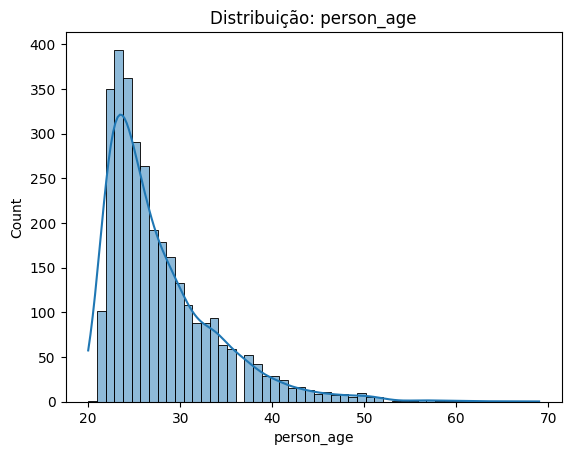

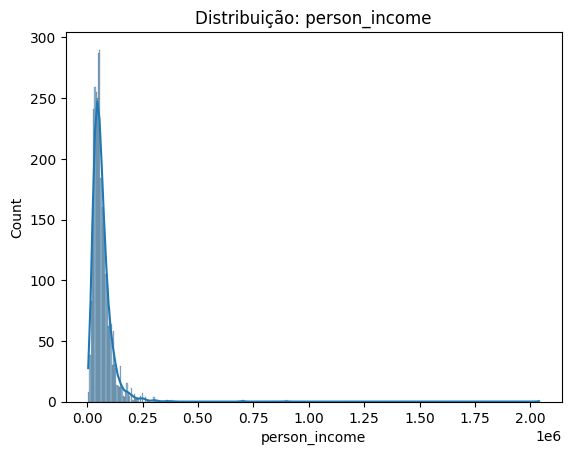

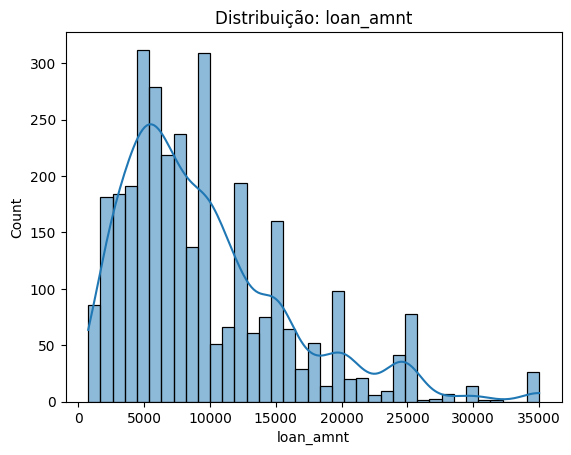

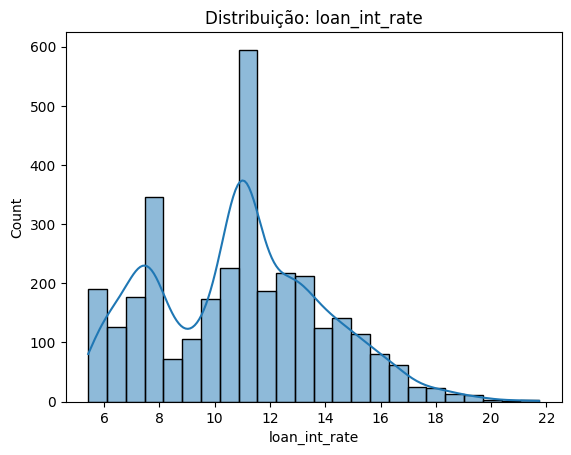

In [ ]:
sample_pd = df.sample(fraction=0.1, seed=42).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ["person_age", "person_income", "loan_amnt", "loan_int_rate"]

for col in numeric_cols:
    sns.histplot(sample_pd[col].dropna(), kde=True)
    plt.title(f"Distribuição: {col}")
    plt.show()


In [ ]:
df.describe(["person_age", "person_income", "loan_amnt", "loan_int_rate"]).show()


+-------+-----------------+-----------------+-----------------+------------------+
|summary|       person_age|    person_income|        loan_amnt|     loan_int_rate|
+-------+-----------------+-----------------+-----------------+------------------+
|  count|            32416|            32416|            32416|             32416|
|   mean|27.74700765054294|66091.64082551826|9593.845631786771|11.014661895359184|
| stddev| 6.35409994731211|62015.58026889566|6322.730240861562|3.0830504659623936|
|    min|               20|             4000|              500|              5.42|
|    max|              144|          6000000|            35000|             23.22|
+-------+-----------------+-----------------+-----------------+------------------+



Idade deve ser entre 18 e 100

In [134]:
df.filter((col("person_age") < 18) | (col("person_age") > 100)).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|       144|      6000000|             MORTGAGE|             12.0|   PERSONAL|         C|     5000|        12.73|          0|                0.0|                        N|                        25|
|       123|        80004|                 RENT|              2.0|  EDUCATION|         B|    20400|        10.25|          0|               0.25|                        N|                         3|
|    

In [ ]:
df = df.filter((col("person_age") >= 18) & (col("person_age") <= 100))

In [ ]:
df.filter((col("person_age") < 18) | (col("person_age") > 100)).show()

Renda deve ser > 0

In [ ]:
df.filter(col("person_income") <= 0).show()

In [ ]:
df = df.filter(col("person_income") > 0)

In [ ]:
df.filter(col("person_income") <= 0).show()

Taxa de juros deve ser positiva e menor que 100%

In [ ]:
df.filter((col("loan_int_rate") <= 0) | (col("loan_int_rate") >= 100)).show()

In [ ]:
df = df.filter((col("loan_int_rate") > 0) & (col("loan_int_rate") < 100))

In [ ]:
df.filter((col("loan_int_rate") <= 0) | (col("loan_int_rate") >= 100)).show()

loan_percent_income = proporção da renda mensal comprometida com o empréstimo.

loan_percent_income = loan_amnt/
person_income

Se ela vale zero, isso indica que:

- O valor do empréstimo (loan_amnt) é zero
ou
- A renda (person_income) é infinita (não é o caso), ou
- Erro de cálculo ou inconsistência no dado



Percentual de renda comprometida com o empréstimo menor que 1 (100%)

In [ ]:
df.filter((col("loan_percent_income") <= 0) | (col("loan_percent_income") > 1)).show()

In [ ]:
df = df.withColumn(
    "loan_percent_income",
    when(
        col("loan_percent_income") == 0,
        (col("loan_amnt") / col("person_income")).cast("double")
    ).otherwise(col("loan_percent_income"))
)

In [ ]:
df.filter(col("loan_percent_income") == 0).show()


Tempo de crédito
A coluna cb_person_cred_hist_length representa o número de anos de histórico de crédito que uma pessoa tem com a agência de crédito (Credit Bureau). É uma medida de maturidade financeira ou experiência de crédito do indivíduo.
Alguém com cb_person_cred_hist_length = 0 está começando agora ou não tem histórico registrado.

Ter um longo histórico geralmente aumenta a confiabilidade do cliente, pois fornece mais dados para prever seu comportamento financeiro. Em contraste, um histórico curto pode representar maior risco ou incerteza para instituições de crédito.

In [ ]:
df.filter(
    (col("cb_person_cred_hist_length").isNull()) |
    (col("cb_person_cred_hist_length") < 1)
).show()

#isNull(): identifica registros onde o campo está ausente.

#< 1: identifica registros com valor igual a 0, ou negativo (caso existam).

In [ ]:
df = df.filter(
    (col("cb_person_cred_hist_length").isNotNull()) &
    (col("cb_person_cred_hist_length") >= 1)
)

Rótulo loan_status:
Loan status (0 -bom is non default 1 - ruim is default)



In [ ]:
df.select("loan_status").distinct().show()

In [ ]:
df = df.filter((col("loan_status") == 0) | (col("loan_status") == 1))

Valores nulos

In [ ]:
df.select([
    count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in df.columns
]).show()

Analisar colunas categóricas com valores inválidos ou incompletos

In [ ]:

for col_name in categorical_cols:
    print(f"Valores únicos da coluna {col_name}:")
    df.select(trim(col(col_name)).alias(col_name)).distinct().show()

In [ ]:
import pyspark.sql.functions as F

# Estatísticas descritivas
df.select(
    F.count("person_income").alias("count"),
    F.mean("person_income").alias("mean"),
    F.expr("percentile(person_income, array(0.5))")[0].alias("median"),
    F.stddev("person_income").alias("stddev"),
    F.min("person_income").alias("min"),
    F.expr("percentile(person_income, array(0.25))")[0].alias("p25"),
    F.expr("percentile(person_income, array(0.75))")[0].alias("p75"),
    F.expr("percentile(person_income, array(0.95))")[0].alias("p95"),
    F.expr("percentile(person_income, array(0.99))")[0].alias("p99"),
    F.max("person_income").alias("max")
).show(truncate=False)


In [ ]:
df.filter(col("person_income") > 300000).count()


Apenas 136 registros (de um total de mais de 32.000) possuem person_income > 300.000.

Eles representam menos de 0,5% do total, o que é estatisticamente irrelevante para o modelo, mas podem causar distorções se não forem removidos.

In [ ]:
df.filter(col("person_income") > 300000).show()


In [ ]:
df = df.filter(col("person_income") <= 300000)

## SALVAR NA CLEAN LAYER
Dados limpos, com valores ausentes tratados, outliers removidos e tipos corrigidos.

Ainda não houve transformação de variáveis categóricas ou escala.

Ideal salvar neste ponto o resultado da limpeza para reuso.

In [ ]:
# df_clean_path = "s3a://credit-risk/clean/credit_risk_cleaned.parquet"

# df.write.mode("overwrite").parquet(df_clean_path)

#Feature Engineering

Feature engineering completo: indexação, encoding, normalização, VectorAssembler, etc.

Serve de base para algoritmos de ML.

## 2. Definir colunas categóricas e numéricas


In [111]:
categorical_cols = [c for c, t in df.dtypes if t == "string"]
numeric_cols = [c for c, t in df.dtypes if t in ["double", "int"]]

In [ ]:
# categorical_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
# numeric_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt",
#                 "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]

Antes de aplicar os algoritmos de clusterização e predição, precisamos transformar os dados para que:

Todas as variáveis estejam em formato numérico, pois os algoritmos de machine learning não trabalham com strings diretamente;

Os dados estejam normalizados ou padronizados (especialmente os numéricos) para garantir desempenho adequado do modelo.

## 3. Preparar indexação e codificação de colunas categóricas


StringIndexer:	Transforma strings categóricas em números (ex: "RENT" → 0, "OWN" → 1...)

In [112]:
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid="keep")
    for c in categorical_cols
]

In [110]:
# numeric_cols = [c for c, t in df.dtypes if t in ["double", "int"]]


In [113]:
pipeline_indexers = Pipeline(stages=indexers)
df_indexed = pipeline_indexers.fit(df).transform(df)
df_indexed.select(categorical_cols + [c + "_indexed" for c in categorical_cols]).show(5)


+---------------------+-----------------+----------+-------------------------+-----------------------------+-------------------+------------------+---------------------------------+
|person_home_ownership|      loan_intent|loan_grade|cb_person_default_on_file|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|
+---------------------+-----------------+----------+-------------------------+-----------------------------+-------------------+------------------+---------------------------------+
|                 RENT|          VENTURE|         C|                        Y|                          0.0|                2.0|               2.0|                              1.0|
|                  OWN|          MEDICAL|         A|                        N|                          2.0|                1.0|               0.0|                              0.0|
|             MORTGAGE|DEBTCONSOLIDATION|         A|                        N|            

In [ ]:
# Opcional: OneHotEncoding (pode ser útil para algoritmos lineares, mas pode ser removido em RandomForest)
# Irei apenas indexar para reduzir complexidade e deixar o modelo mais leve
# Mas para uso de OneHotEncoder:
# encoders = [
#     OneHotEncoder(inputCol=col_name + "_indexed", outputCol=col_name + "_ohe")
#     for col_name in categorical_cols
# ]



## 4. Escalar colunas numéricas (normalização: média = 0, desvio = 1)

* StandardScaler:	Padroniza as variáveis numéricas para mesma escala
* VectorAssembler:	Junta as features em um vetor único para os modelos

In [114]:
assembler_numeric = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="numeric_features_assembled"
)

In [115]:
df_numeric_assembled = assembler_numeric.transform(df_indexed)
df_numeric_assembled.select(numeric_cols + ["numeric_features_assembled"]).show(5, truncate=False)

+----------+-------------+-----------------+---------+-------------+-----------+-------------------+--------------------------+-----------------------------------------------+
|person_age|person_income|person_emp_length|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_cred_hist_length|numeric_features_assembled                     |
+----------+-------------+-----------------+---------+-------------+-----------+-------------------+--------------------------+-----------------------------------------------+
|24        |60000        |3.0              |22000    |14.26        |1          |0.37               |2                         |[24.0,60000.0,3.0,22000.0,14.26,1.0,0.37,2.0]  |
|21        |19000        |5.0              |6000     |8.49         |1          |0.32               |3                         |[21.0,19000.0,5.0,6000.0,8.49,1.0,0.32,3.0]    |
|21        |19253        |4.0              |6250     |6.17         |1          |0.32               |3                   

In [116]:
scaler = StandardScaler(
    inputCol="numeric_features_assembled",
    outputCol="numeric_features_scaled",
    withMean=True,
    withStd=True
)

In [117]:
scaler_model = scaler.fit(df_numeric_assembled)
df_scaled = scaler_model.transform(df_numeric_assembled)
df_scaled.select("numeric_features_assembled", "numeric_features_scaled").show(5, truncate=False)

+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|numeric_features_assembled                     |numeric_features_scaled                                                                                                                                         |
+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[24.0,60000.0,3.0,22000.0,14.26,1.0,0.37,2.0]  |[-0.5896991991962687,-0.09822758731120795,-0.43244539542089866,1.9621514591966276,1.0526386578711433,1.8901344082618188,1.870109849035227,-0.9389673300869897]  |
|[21.0,19000.0,5.0,6000.0,8.49,1.0,0.32,3.0]    |[-1.0618353042112756,-0.7593517729146737,0.05650298051087537,-0.5684009114545313,-0.8188843884435908,1.8901

## 5. Combinar features finais (categóricas indexadas + numéricas escaladas)


In [119]:
final_feature_cols = [c + "_indexed" for c in categorical_cols] + ["numeric_features_scaled"]

final_assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="features"
)

In [120]:
df_final = final_assembler.transform(df_scaled)

df_final.select("features", "loan_status").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|features                                                                                                                                                                        |loan_status|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[0.0,2.0,2.0,1.0,-0.5896991991962687,-0.09822758731120795,-0.43244539542089866,1.9621514591966276,1.0526386578711433,1.8901344082618188,1.870109849035227,-0.9389673300869897]  |1          |
|[2.0,1.0,0.0,0.0,-1.0618353042112756,-0.7593517729146737,0.05650298051087537,-0.5684009114545313,-0.8188843884435908,1.8901344082618188,1.4019975351997234,-0.6926030721762416] |1          |
|[1.0,4.0,0.0,0.0,-1.0618353042112756,-0.7552

## 6.Construir pipeline completo


Pipeline:	Automatiza o processo acima com um fit/transform
loan_status	Usado como label para algoritmos supervisionados

In [121]:
pipeline = Pipeline(stages=indexers + [assembler_numeric, scaler, final_assembler])

In [122]:
print(pipeline.getStages())

[StringIndexer_69f61794b2ad, StringIndexer_e29016c9d8e1, StringIndexer_02cac43f6e9b, StringIndexer_f5ffc77aaffc, VectorAssembler_b52b75b50958, StandardScaler_d7c6be4db582, VectorAssembler_807b8af4ff9a]


## 7. Treinar e transformar os dados


In [123]:
pipeline_model = pipeline.fit(df)
df_enriched = pipeline_model.transform(df)

# 8. Selecionar apenas o que importa para ML


loan_status: Usado como label para algoritmos supervisionados

In [125]:
df_enriched.select("features", "loan_status", *categorical_cols, *numeric_cols).show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------------------+-----------------+----------+-------------------------+----------+-------------+-----------------+---------+-------------+-----------+-------------------+--------------------------+
|features                                                                                                                                                                        |loan_status|person_home_ownership|loan_intent      |loan_grade|cb_person_default_on_file|person_age|person_income|person_emp_length|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_cred_hist_length|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------------------+

In [126]:
df_enriched.show()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+-------------------+------------------+---------------------------------+--------------------------+-----------------------+--------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|numeric_features_assembled|numeric_features_scaled|            features|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+------

## 9. Salvar como camada enriched


In [ ]:
# df_enriched.write.mode("overwrite").parquet("s3a://credit-risk/enriched/credit_risk_enriched.parquet")


#Clusterização com KMeans

In [101]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

## Treina o modelo de KMeans


In [128]:
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=42)
kmeans_model = kmeans.fit(df_enriched)

## Aplica o modelo para obter os clusters


In [129]:
df_clustered = kmeans_model.transform(df_enriched)

## Avalia os clusters com índice de Silhouette


In [130]:
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(df_clustered)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.2298


Como temos dados reais com certa complexidade, e estamos usando técnicas não supervisionadas (como K-Means), um Silhouette Score entre 0.3 e 0.6 já pode ser considerado aceitável.

Scores muito altos (>0.7) são raros com dados financeiros reais, pois os grupos tendem a se sobrepor naturalmente (ex: dois clientes diferentes podem ter renda parecida mas perfis distintos de risco).

# Contagem por cluster

In [131]:
df_clustered.groupBy("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|11395|
|      3| 5760|
|      2| 6724|
|      0| 8537|
+-------+-----+



# Média das variáveis por cluster (exemplo: person_income e loan_amnt)


In [132]:
df_clustered.groupBy("cluster").avg("person_income", "loan_amnt", "loan_int_rate").show()

+-------+------------------+------------------+------------------+
|cluster|avg(person_income)|    avg(loan_amnt)|avg(loan_int_rate)|
+-------+------------------+------------------+------------------+
|      1| 62235.59701623519| 8119.449319877139| 9.691194383501752|
|      3|60965.988020833334|12346.032986111111|14.157619791666763|
|      2|  59857.3991671624|10877.714158239143|13.114022903034083|
|      0| 79607.21072976456| 8693.695091952677| 9.007091484127875|
+-------+------------------+------------------+------------------+



In [ ]:
## Salva resultado com cluster


In [ ]:
# df_clustered.write.mode("overwrite").parquet("s3a://credit-risk/clustered/credit_risk_clustered.parquet")
